In [59]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import scipy.stats
import pandas
import itertools
import datetime
import os
import matplotlib
import mpl_toolkits.axes_grid1

from mpl_toolkits import basemap

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Alternative test:  instead of using month-specific percentiles, use percentiles over whole season

In [8]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [9]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]
year_start = 1920
year_end = 2100

In [10]:
year_start_list = numpy.arange(1920,2071)
year_end_list = numpy.arange(1950,2101)

whiplash_ratios_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_pic_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_rcp_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))

# create list of names of members '001','002','003', ...
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'

In [11]:
# create season strings
years_hist_rcp = numpy.arange(1920, 2100+1, 1).astype(numpy.int)

idx_2003 = numpy.where(years_hist_rcp==2003)[0][0]
idx_2033 = numpy.where(years_hist_rcp==2033)[0][0]
idx_2070 = numpy.where(years_hist_rcp==2070)[0][0]
idx_2100 = numpy.where(years_hist_rcp==2100)[0][0]

season_strings_hist_rcp = [str(years_hist_rcp[i])+'-'+str(years_hist_rcp[i+1]) for i in range(years_hist_rcp.size-1)]
#print(season_strings_hist_rcp[idx_2003:idx_2033])

n_seasons_hist_rcp = 2100-1920
#print(len(season_strings_hist_rcp))

In [12]:
# import monthly pic data
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain_MONTHLY_TOTALS/'
monthly_data_pic = numpy.load(working_dir+'member_005_years_0402-2200_threshold_0.1mmday_whole_domain.npy')
#print(monthly_data_pic.shape)
# (26, 25, 1799, 12)

monthly_data_pic_NDJFM = numpy.zeros((26,25,1798,5))

monthly_data_pic_NDJFM[:,:,:,0] = monthly_data_pic[:,:,:1798,10]
monthly_data_pic_NDJFM[:,:,:,1] = monthly_data_pic[:,:,:1798,11]
monthly_data_pic_NDJFM[:,:,:,2] = monthly_data_pic[:,:,1:,0]
monthly_data_pic_NDJFM[:,:,:,3] = monthly_data_pic[:,:,1:,1]
monthly_data_pic_NDJFM[:,:,:,4] = monthly_data_pic[:,:,1:,2]

In [13]:
# import monthly RCP data
monthly_data_hist_rcp = []
for ens_name in ensemble_names:
    monthly_data_hist_rcp.append(numpy.load(working_dir+'PRECT_monthly_data_member_' +ens_name+ '_years_1920-2100_threshold_0.1mmday_whole_domain.npy'))
monthly_data_hist_rcp = numpy.array((monthly_data_hist_rcp))
#print(monthly_data_hist_rcp.shape)
# (40, 26, 25, 181, 12)

# store just NDJFM
monthly_data_hist_rcp_NDJFM = numpy.zeros((40,26,25,180,5))
monthly_data_hist_rcp_NDJFM[:,:,:,:,0] = monthly_data_hist_rcp[:,:,:,:180,10]
monthly_data_hist_rcp_NDJFM[:,:,:,:,1] = monthly_data_hist_rcp[:,:,:,:180,11]
monthly_data_hist_rcp_NDJFM[:,:,:,:,2] = monthly_data_hist_rcp[:,:,:,1:,0]
monthly_data_hist_rcp_NDJFM[:,:,:,:,3] = monthly_data_hist_rcp[:,:,:,1:,1]
monthly_data_hist_rcp_NDJFM[:,:,:,:,4] = monthly_data_hist_rcp[:,:,:,1:,2]

In [14]:
print(monthly_data_pic_NDJFM.shape)
print(monthly_data_hist_rcp_NDJFM.shape)

(26, 25, 1798, 5)
(40, 26, 25, 180, 5)


# Calculate stdev at each lat/lon grid point for each year

In [15]:
monthly_stdev_hist_rcp = numpy.zeros((26,25,180))
monthly_stdev_pic = numpy.zeros((26,25))

for i in range(26):
    for j in range(25):
        for t in range(180):
            monthly_stdev_hist_rcp[i,j,t] = numpy.std( monthly_data_hist_rcp_NDJFM[:,i,j,t,:].flatten(), ddof=1 )

for i in range(26):
    for j in range(25):
        monthly_stdev_pic[i,j] = numpy.std( monthly_data_pic_NDJFM[i,j,:,:].flatten(), ddof=1 )

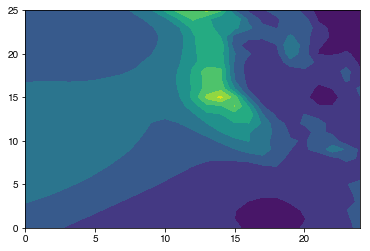

In [16]:
mp.contourf(monthly_stdev_pic)

In [17]:
year_middle_list = numpy.arange(1921,2101)

In [18]:
monthly_stdev_hist_rcp_LA = monthly_stdev_hist_rcp[9,17,:]

In [43]:
window=10
half_window=int(window/2)
monthly_stdev_hist_rcp_LA_rolling_mean = pandas.Series(monthly_stdev_hist_rcp_LA).rolling(window=window, center=True).mean()

# standard error on hist+rcp8.5
std_error = numpy.zeros((monthly_stdev_hist_rcp_LA.shape))*numpy.nan
for t in range(half_window, 180-half_window):
    std_error[t] = numpy.std(monthly_stdev_hist_rcp_LA[(t-half_window):(t+half_window)], ddof=1)/numpy.sqrt(window)

# standard error on pic


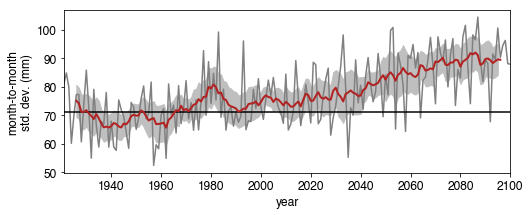

In [44]:
fontsize = 12
fig = mp.figure(figsize=(8,3))

ax = fig.add_subplot(111)

ax.plot(year_middle_list, monthly_stdev_hist_rcp_LA, c='0.5')

ax.axhline(monthly_stdev_pic[9,17], c='0')

ax.plot(year_middle_list, monthly_stdev_hist_rcp_LA_rolling_mean, c='firebrick', lw=2)
ax.set_xlim(year_middle_list.min(), year_middle_list.max())

ax.fill_between(year_middle_list, monthly_stdev_hist_rcp_LA_rolling_mean-1.96*std_error, monthly_stdev_hist_rcp_LA_rolling_mean+1.96*std_error, color='0.75')   

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('year', fontsize=fontsize)
ax.set_ylabel('month-to-month\nstd. dev. (mm)', fontsize=fontsize)

fig.savefig('month_to_month_stdev_for_LA.pdf', bbox_inches='tight', transparent=True)

# plot percent change in stdev
* do for last 30 years of hist+rcp8.5
* and for preindustrial control

In [54]:
# last 30 years of stdev
print(monthly_stdev_hist_rcp.shape)
monthly_stdev_hist_rcp_last30yr_mean = numpy.mean(monthly_stdev_hist_rcp[:,:,-30:], axis=2)

(26, 25, 180)


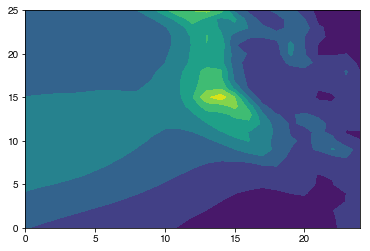

In [55]:
mp.contourf(monthly_stdev_hist_rcp_last30yr_mean)

In [63]:
perc_change = (monthly_stdev_hist_rcp_last30yr_mean - monthly_stdev_pic) / monthly_stdev_pic * 100.

In [64]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

In [65]:
# make color map
minval=0.0 # 
maxval=0.85 #
n=256
full_cmap = mp.get_cmap('RdBu')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

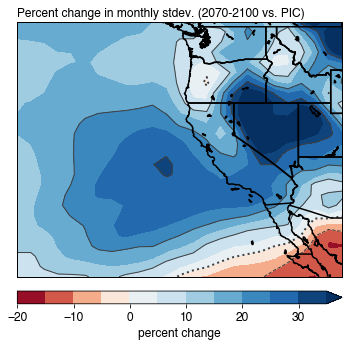

In [72]:
fontsize=12
contour_levels = numpy.arange(-20,36,5)

fig = mp.figure(figsize=(5,5))

ax = fig.add_subplot(111)
map = basemap.Basemap(projection='cyl',ax=ax, llcrnrlat=PRECT_lat.min(),urcrnrlat=PRECT_lat.max(),llcrnrlon=PRECT_lon.min(),urcrnrlon=PRECT_lon.max(),resolution='i')
map.fillcontinents(color='0.75',lake_color='0.5')
map.drawmapboundary(fill_color='0')

map.drawcoastlines(linewidth=1.5, color='0', zorder=3)
map.drawstates(linewidth=1.5, color='0', zorder=3)
map.drawcountries(linewidth=1.5, color='0', zorder=3)

lons,lats = numpy.meshgrid(PRECT_lon, PRECT_lat)
xi,yi = map(lons, lats)

#pr_map = map.contourf(xi, yi, count_ratio_2d, cmap='gist_earth_r', levels=contour_levels, zorder=2, extend='max', latlon=True)

pr_map = map.contourf(xi, yi, perc_change, \
                      #cmap='inferno', \
                      cmap='RdBu', \
                      norm=MidpointNormalize(midpoint=0.0), \
                      levels=contour_levels, \
                      zorder=2, \
                      extend='max', \
                      latlon=True)
contour_plot = pr_contour = map.contour(xi, yi, perc_change, \
                         levels=[-20,-10,0,10,20,30], \
                         colors='0.25', \
                         linewidths=[1]*2+[2]+[1]*3, \
                         linestyles=['--']*2+[':']+['-']*3, \
                         )

# new_levels = []
# for i in contour_plot.levels:
#     if i in [0.5,1.5]:
#         new_levels.append('{:.1f}'.format(i))
#     else:
#         new_levels.append('{:.0f}'.format(i))
# contour_plot.levels = new_levels
# mp.clabel(contour_plot, fontsize=fontsize-2, colors=['0.25']*7+['0.75']*5)

divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='5%', pad=0.2) #fig.add_axes([0.0, -0.02, 1.0, 0.03])
cbar = fig.colorbar(pr_map, cax=cbar_ax, orientation='horizontal')

cbar.set_label('percent change', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_ticks(contour_levels)
#cbar.set_ticks([0,1,2,3,4,5,6,7,8,9,10])

ax.text(s='Percent change in monthly stdev. (2070-2100 vs. PIC)', x=0, y=1.01, transform=ax.transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.tight_layout()
mp.savefig('perc_change_monthly_stdev.pdf', transparent=True, bbox_inches='tight')

# netcdf file

In [ ]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [ ]:
# convert times
time_datetime = [datetime.datetime(i,1,15) for i in year_middle_list]
time_nc = netCDF4.date2num(time_datetime, units='days since 1920-01-01', calendar='standard')

In [73]:
# save hist clim

filename = 'month_to_month_std_dev_values.nc'

if os.path.exists(filename):
    os.remove(filename)

ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')

lat_dim = ncfile.createDimension('lat', PRECT_lat.size)
lon_dim = ncfile.createDimension('lon', PRECT_lon.size)

lat_var = ncfile.createVariable('lat', 'f4', ('lat',))
lon_var = ncfile.createVariable('lon', 'f4', ('lon',))
lat_var[:] = PRECT_lat
lon_var[:] = PRECT_lon
lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

time_dim = ncfile.createDimension('time', len(year_middle_list))
time_var = ncfile.createVariable('time', 'f4', ('time',))
time_var[:] = time_nc
time_var.units = 'days since 1920-01-01'

stdev_all_latlon_time_series = ncfile.createVariable('stdev_all_latlon_time_series', 'f4', ('time','lat','lon',))
stdev_all_latlon_time_series[:] = monthly_stdev_hist_rcp.transpose(2,0,1)
stdev_all_latlon_time_series.units = 'mm'
stdev_all_latlon_time_series.description = 'Entire 180-season time series of grid point values of NDJFM stdev. across 40 ens. members'

stdev_LA_time_series = ncfile.createVariable('stdev_LA_time_series', 'f4', ('time'))
stdev_LA_time_series[:] = monthly_stdev_hist_rcp_LA
stdev_LA_time_series.units = 'mm'
stdev_LA_time_series.description = '180-season time series for LA-specific grid point (corresdoning to 10th row and 18th column, or [9,17] in Python indexing)'

stdev_LA_time_series_10yr = ncfile.createVariable('stdev_LA_time_series_10yr', 'f4', ('time'), fill_value=numpy.nan)
stdev_LA_time_series_10yr[:] = numpy.array((monthly_stdev_hist_rcp_LA_rolling_mean))
stdev_LA_time_series_10yr.units = 'mm'
stdev_LA_time_series_10yr.description = '10yr rolling mean of original LA time series'

stdev_LA_time_series_10yr_error_bar = ncfile.createVariable('stdev_LA_time_series_error_bar', 'f4', ('time'), fill_value=numpy.nan)
stdev_LA_time_series_10yr_error_bar[:] = 1.96*std_error
stdev_LA_time_series_10yr_error_bar.units = 'mm'
stdev_LA_time_series_10yr_error_bar.description = 'Error bar magnitude for 10yr rolling mean (plus/minus to get full range)'

pic_stdev_value_LA = ncfile.createVariable('pic_stdev_value_LA', 'f4')
pic_stdev_value_LA[:] = monthly_stdev_pic[9,17]
pic_stdev_value_LA.units = 'mm'
pic_stdev_value_LA.description = 'LA specific stdev. value from preindustrial control (NDJFM for 1798 seasons)'

pic_stdev_value_all_latlon = ncfile.createVariable('pic_stdev_value_all_latlon', 'f4', ('lat','lon',))
pic_stdev_value_all_latlon[:] = monthly_stdev_pic
pic_stdev_value_all_latlon.units = 'mm'
pic_stdev_value_all_latlon.description = 'Preindustrial control stdev. values across NDJFM for all grid points and all 1798 seasons'

perc_change_rcp = ncfile.createVariable('perc_change', 'f4', ('lat','lon',))
perc_change_rcp[:] = perc_change
perc_change_rcp.units = 'percent'
perc_change_rcp.description = 'Calculated as:  (last 30 years of RCP8.5 MINUS preindustrial) DIVIDED BY (preindustrial)'

ncfile.close()

In [74]:
print(monthly_stdev_pic[9,17])

71.0264466
